# Introduction

Report estimated number of cells for the released ENCODE4 human & mouse sc/snRNA-seq experiments.

See "expected cells" line in
- [Human Summary](#Human-Summary)
- [Mouse Summary](#Mouse-Summary)

This should be runnable in mybinder if you want to experiment with it.

I also plotted swarm plots the other measured metrics as well.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh//github.com/ENCODE-AWG/encode-202006-jamboree-detrout-rna-sc-pipeline.git/HEAD?labpath=count-encode4-scrna-seq-estimated-cells.ipynb)

In [1]:
import sys
from pathlib import Path

!{sys.executable} -m pip install encoded_client

In [2]:
import pandas
from matplotlib import pyplot, colors
import seaborn
from tqdm import tqdm

from encoded_client.encoded import ENCODED, get_object_type

In [3]:
server = ENCODED("www.encodeproject.org")

In [4]:
def format_alias(alias):
    return ",".join([x.split(':')[1] for x in alias])

def filter_gene_type_metric(metric):
    to_remove = [
        "@id", 
        "@type", 
        "aliases", 
        "assay_term_name",
        "assay_term_id",
        "attachment", 
        "date_created", 
        "quality_metric_of", 
        "schema_version",
        "status",
        "step_run",
        "submitted_by",
        "lab", 
        "award", 
        "uuid"
    ]
    filtered_metric = metric.copy()
    for remove in to_remove:
        if remove in filtered_metric:
            del filtered_metric[remove]
        else:
            print("Warning {} not found".format(remove))
    return filtered_metric


def plot_gene_type_metric(gene_types):
    f = pyplot.figure(figsize=(8,8))
    ax = f.add_subplot(1,1,1)
    return gene_types.T.plot.bar(stacked=True, ax=ax)

    
def report_experiment(experiment):  
    star_quality = {}

    probably_nucleus = (
        "ENCSR753YOZ",
        "ENCSR906MRL",
        "ENCSR345CVL",
        "ENCSR349AHE",
        "ENCSR991LHO",
        "ENCSR630LZS", 
        "ENCSR273JWD",
        "ENCSR654MFX",
        "ENCSR204RHR",
        "ENCSR084XKX",
        "ENCSR203YOV",
        "ENCSR138JCM",
        "ENCSR067BOK",
        "ENCSR540DHJ",
        "ENCSR489URW",
        "ENCSR762LML",
        "ENCSR994VEG",
        "ENCSR962JKS",
        "ENCSR980OCK",
        "ENCSR681GPY",
        "ENCSR176WWW",
        "ENCSR237HWJ",
        "ENCSR398YBK",
        "ENCSR455MGH",
        "ENCSR899GYX",
        "ENCSR175TRJ",
        "ENCSR485GOL",
        "ENCSR190TRK",
        "ENCSR093GXF",
        "ENCSR328GTN",
        "ENCSR763BII",
        "ENCSR231FNL",
        "ENCSR002SMQ",
        "ENCSR814LMX",
        "ENCSR076ZLE",
        "ENCSR919ENI",
        "ENCSR157FDD",
        "ENCSR488UUT",
        "ENCSR085XEW",
        "ENCSR851JBE",
        "ENCSR008CVR",
        "ENCSR056QLB",
        "ENCSR777RUZ",
        "ENCSR788SNY",
    )
    #assert len(experiment.replicates) == 1
    alias = format_alias(experiment["aliases"])
    for replicate in experiment.replicates:
        library = replicate["library"]
        biosample = library["biosample"]
        
        if biosample.get("subcellular_fraction_term_name") == "nucleus" or experiment["accession"] in probably_nucleus:
            mean_gene = 'mean_genefull_ex50pas_per_cell'
            median_gene = 'median_genefull_ex50pas_per_cell'
            reads_mapped_to_multi_gene = 'reads_mapped_to_genefull_ex50pas_unique_and_multiple_gene_ex50pas'
            reads_mapped_to_unique_gene = 'reads_mapped_to_genefull_ex50pas_unique_genefull_ex50pas'
            total_genes_detected = "total_genefull_ex50pas_detected"
            unique_reads_mapped_to_gene = 'unique_reads_in_cells_mapped_to_genefull_ex50pas'
        else:
            mean_gene = 'mean_gene_per_cell'
            median_gene = 'median_gene_per_cell'
            reads_mapped_to_multi_gene = "reads_mapped_to_gene_unique_and_multiple_gene"
            reads_mapped_to_unique_gene = 'reads_mapped_to_gene_unique_gene'
            total_genes_detected = "total_gene_detected"
            unique_reads_mapped_to_gene = 'unique_reads_in_cells_mapped_to_gene'
            
            
        for file in replicate.files:
            for i, metric in enumerate(file["quality_metrics"]):
                metric_for = ",".join(file._json["quality_metrics"][i]["quality_metric_of"])

                if get_object_type(metric) == "StarQualityMetric":
                    mapped = metric['Number of reads mapped to multiple loci'] + metric['Uniquely mapped reads number']
                    fraction_mapped = mapped / metric['Number of input reads']                    
                    star_quality.setdefault(alias, {}).update({
                        'multi': metric['Number of reads mapped to multiple loci'],
                        'uniq': metric['Uniquely mapped reads number'],
                        'mapped': mapped,
                        'total': metric['Number of input reads'],
                        '%mapped': fraction_mapped,
                        #"{:.4}".format(fraction_mapped * 100),
                    })
                elif get_object_type(metric) == "StarSoloQualityMetric":
                    try:
                        star_quality.setdefault(alias, {}).update({
                            'estimated_number_of_cells': int(metric['estimated_number_of_cells']),
                            'fraction_of_unique_reads_in_cells': metric['fraction_of_unique_reads_in_cells'],
                            'mean_UMI_per_cell': metric['mean_UMI_per_cell'],
                            'mean_gene*_per_cell': metric[mean_gene],
                            'mean_reads_per_cell': metric['mean_reads_per_cell'],
                            'median_UMI_per_cell': metric['median_UMI_per_cell'],
                            'median_gene*_per_cell': metric[median_gene],
                            'median_reads_per_cell': metric['median_reads_per_cell'],
                            'number_of_reads': metric['number_of_reads'],
                            'q30_bases_in_CB_UMI': metric['q30_bases_in_CB_UMI'],
                            'q30_bases_in_rna_read': metric['q30_bases_in_rna_read'],
                            'reads_mapped_to_gene*_unique_and_multiple_gene*': metric[reads_mapped_to_multi_gene],
                            'reads_mapped_to_gene*_unique_gene*': metric[reads_mapped_to_unique_gene],
                            'reads_mapped_to_genome_unique': metric["reads_mapped_to_genome_unique"],
                            'reads_mapped_to_genome_unique_and_multiple': metric['reads_mapped_to_genome_unique_and_multiple'],
                            'reads_with_valid_barcodes': metric['reads_with_valid_barcodes'],
                            'sequencing_saturation': metric['sequencing_saturation'],
                            'total_gene*_detected': metric[total_genes_detected],
                            'umis_in_cells': metric['umis_in_cells'],
                            'unique_reads_in_cells_mapped_to_gene*': metric[unique_reads_mapped_to_gene],
                        })
                    except KeyError as e:
                        print("Experiment {} {} error {}".format(experiment["accession"], experiment["aliases"], str(e)))


    return star_quality
   

In [5]:
def plot_summary_statistics(qc_statistics):
    f = pyplot.figure(figsize=(10,60))
    n = len(qc_statistics.columns)

    for i, column in enumerate(qc_statistics):
        ax = f.add_subplot(n,1,i+1)
        #ax.set_yticklabels([column])
        ax.set_title(column)
        seaborn.swarmplot(data=qc_statistics, x=column, palette="deep", orient="h", size=4, ax=ax)
    f.tight_layout()

In [6]:
def download_star_stats(query):    
    graph = server.get_json(query, limit="all")

    experiment_id = graph["@graph"][0]["@id"]
    experiment = server.get_experiment(experiment_id)
    alias_id_map = {}
    results = {}

    for row in tqdm(graph["@graph"]):
        experiment_id = row["@id"]
        experiment = server.get_experiment(experiment_id)
        statistics = report_experiment(experiment)
        results.update(statistics)
        if len(statistics) > 0:
            alias_name = list(statistics.keys())[0]
            alias_id_map[alias_name] = experiment_id

    return pandas.DataFrame(results).T

In [7]:
query = "https://www.encodeproject.org/search/?type=Experiment&status=released&assay_title=scRNA-seq&award.rfa=ENCODE4&replicates.library.biosample.donor.organism.scientific_name=Mus+musculus"

    


# Human Summary

100%|██████████| 119/119 [00:23<00:00,  5.07it/s]


expected cells 1633082.0


/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


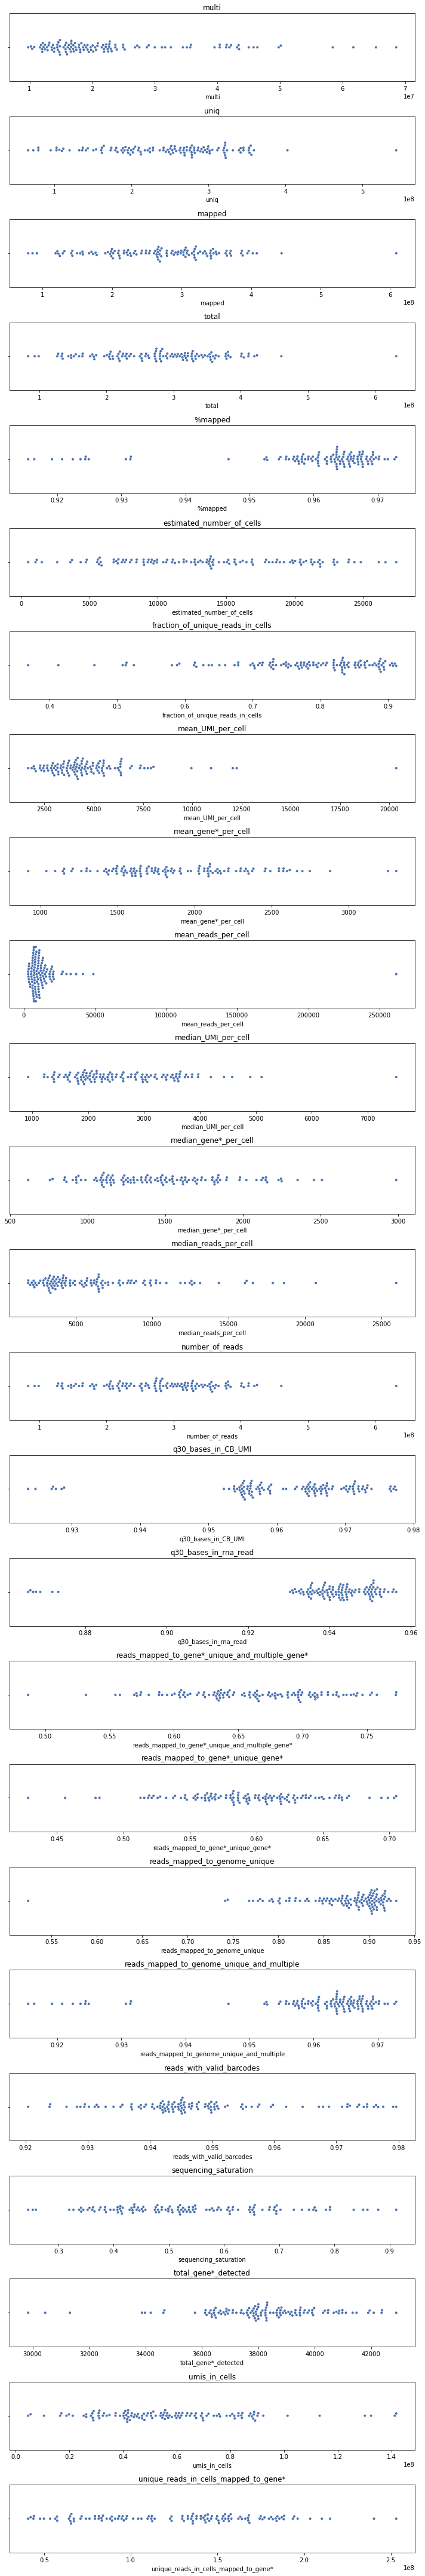

In [8]:
query = "https://www.encodeproject.org/search/?type=Experiment&status=released&assay_title=scRNA-seq&award.rfa=ENCODE4&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens"

human_stats = download_star_stats(query)

print("expected cells", human_stats["estimated_number_of_cells"].sum())

plot_summary_statistics(human_stats)

# Mouse summary

100%|██████████| 273/273 [00:53<00:00,  5.07it/s]


expected cells 674075.0


/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the m

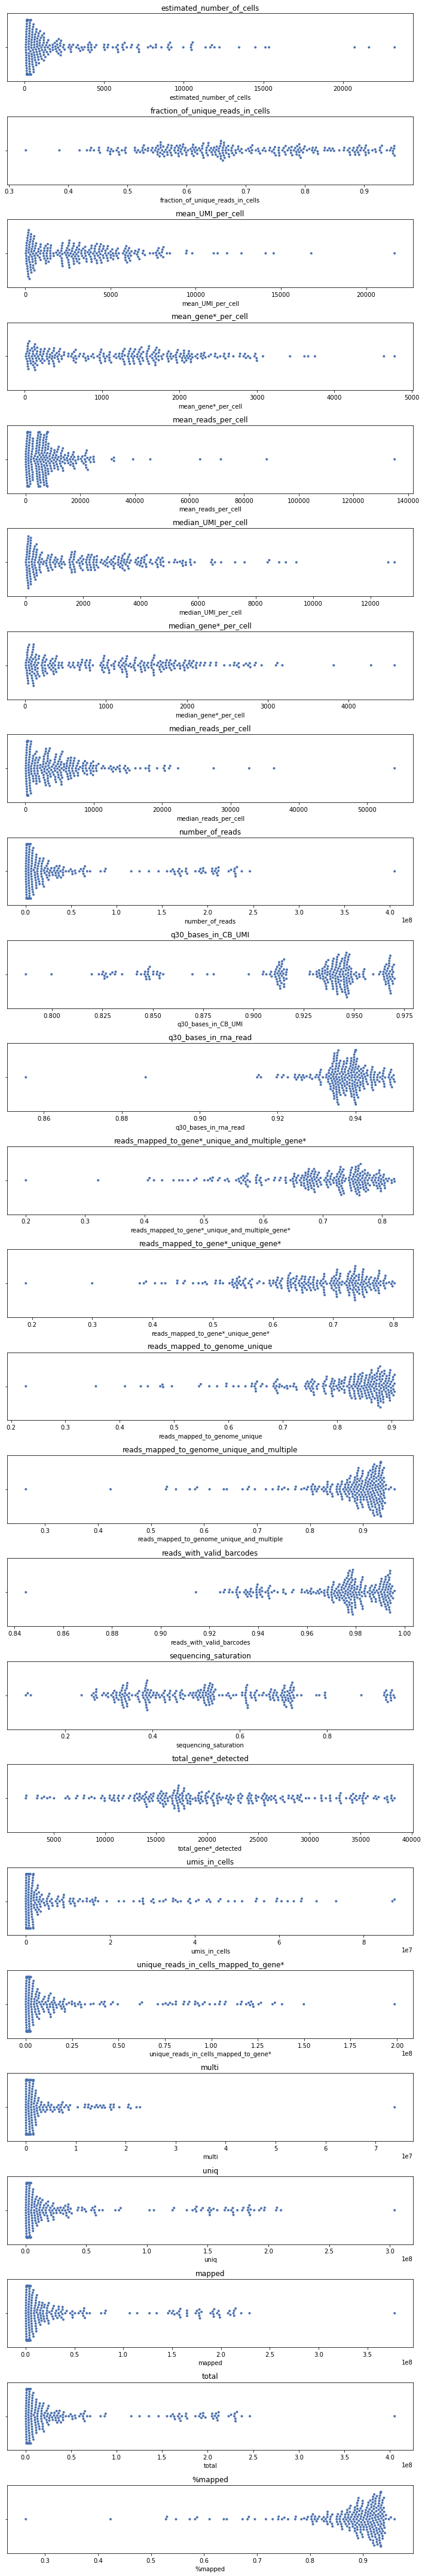

In [9]:
query = "https://www.encodeproject.org/search/?type=Experiment&status=released&assay_title=scRNA-seq&award.rfa=ENCODE4&replicates.library.biosample.donor.organism.scientific_name=Mus+musculus"

mouse_stats = download_star_stats(query)

print("expected cells", mouse_stats["estimated_number_of_cells"].sum())

plot_summary_statistics(mouse_stats)